<a href="https://colab.research.google.com/github/sarojrajdas/Extensive-Vision-AI/blob/master/Assignment_13/ViT_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install the ViT PyTorch package and Linformer 

In [ ]:
pip install vit-pytorch linformer

# loading Libraries

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import Linformer

In [ ]:
from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function

# import torch and related libraries 

In [ ]:
import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset

#to unzip the datasets
import zipfile

#sklearn to split the data

In [ ]:
from sklearn.model_selection import train_test_split

#defining batch size, epocs, learning rate and gamma for training 

In [ ]:
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler

#Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
os.chdir('drive/MyDrive/EVA6/Assignment13')

#Load data

In [ ]:
os.makedirs('data', exist_ok=True)
train_dir = 'data/train'
test_dir = 'data/test'

#Unzipping dataset
with zipfile.ZipFile('train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('test.zip') as test_zip:
    test_zip.extractall('data')

#Creating train and test list 

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

#printing length of the dataset

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


#Defining labels

In [ ]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

# printing few images 

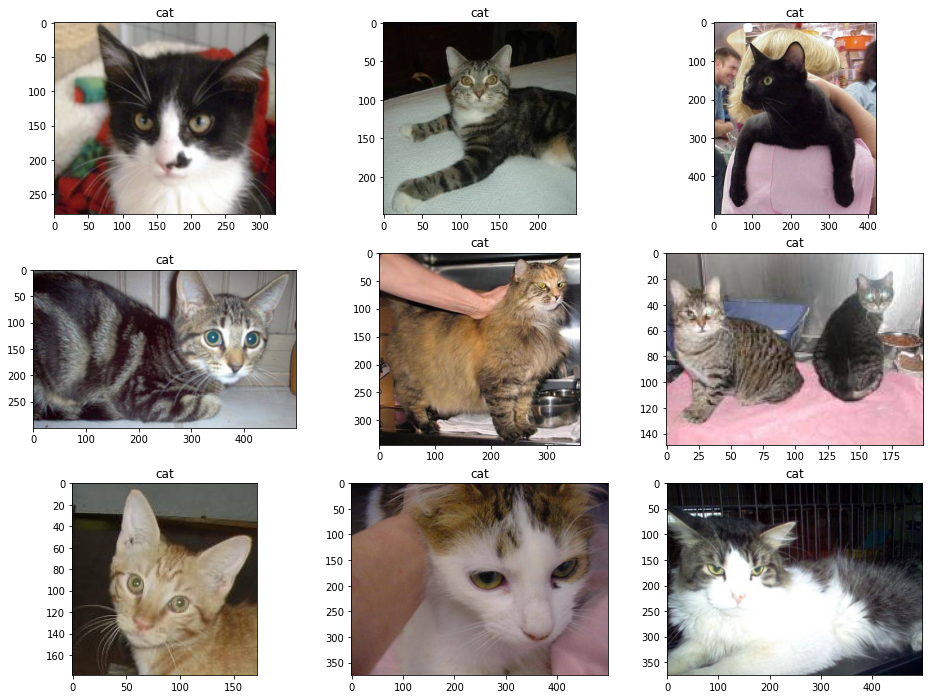

In [ ]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

#Splitting train and validation list

In [ ]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


# Torch transforms

In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

#Loading dataset for training 

In [ ]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

#defining train, validation and test dataset

In [ ]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

#loading dataloader

In [ ]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

#Line transformer 

In [ ]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [ ]:
use_cuda = torch.cuda.is_available()
device = 'cuda:0' if use_cuda else 'cpu'

#Visual transformer

In [ ]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

# loss function

In [ ]:
criterion = nn.CrossEntropyLoss()

# optimizer

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)

# scheduler

In [ ]:
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

#start training

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


Epoch : 1 - loss : 0.6955 - acc: 0.5068 - val_loss : 0.6966 - val_acc: 0.4970




Epoch : 2 - loss : 0.6907 - acc: 0.5255 - val_loss : 0.6854 - val_acc: 0.5562




Epoch : 3 - loss : 0.6853 - acc: 0.5477 - val_loss : 0.6806 - val_acc: 0.5508




Epoch : 4 - loss : 0.6758 - acc: 0.5795 - val_loss : 0.6732 - val_acc: 0.5862




Epoch : 5 - loss : 0.6752 - acc: 0.5734 - val_loss : 0.6659 - val_acc: 0.5938




Epoch : 6 - loss : 0.6664 - acc: 0.5887 - val_loss : 0.6750 - val_acc: 0.5698




Epoch : 7 - loss : 0.6563 - acc: 0.6005 - val_loss : 0.6502 - val_acc: 0.6036




Epoch : 8 - loss : 0.6457 - acc: 0.6183 - val_loss : 0.6508 - val_acc: 0.6078




Epoch : 9 - loss : 0.6391 - acc: 0.6270 - val_loss : 0.6448 - val_acc: 0.6175




Epoch : 10 - loss : 0.6319 - acc: 0.6324 - val_loss : 0.6295 - val_acc: 0.6292




Epoch : 11 - loss : 0.6255 - acc: 0.6417 - val_loss : 0.6308 - val_acc: 0.6406




Epoch : 12 - loss : 0.6199 - acc: 0.6499 - val_loss : 0.6249 - val_acc: 0.6466




Epoch : 13 - loss : 0.6138 - acc: 0.6518 - val_loss : 0.6135 - val_acc: 0.6529




Epoch : 14 - loss : 0.6089 - acc: 0.6581 - val_loss : 0.6274 - val_acc: 0.6394




Epoch : 15 - loss : 0.6044 - acc: 0.6643 - val_loss : 0.6182 - val_acc: 0.6529




Epoch : 16 - loss : 0.6051 - acc: 0.6675 - val_loss : 0.6108 - val_acc: 0.6531




Epoch : 17 - loss : 0.6003 - acc: 0.6660 - val_loss : 0.6009 - val_acc: 0.6752




Epoch : 18 - loss : 0.5981 - acc: 0.6662 - val_loss : 0.6028 - val_acc: 0.6634




Epoch : 19 - loss : 0.5952 - acc: 0.6750 - val_loss : 0.5998 - val_acc: 0.6681




Epoch : 20 - loss : 0.5908 - acc: 0.6762 - val_loss : 0.5872 - val_acc: 0.6810

